In [1]:
from functions import *
import cmapy

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Only GPU 1 is visible to this code

In [ ]:
# try gsb dataset
# cl_2800 = np.genfromtxt("crl2800_sc_formatted_region_(1565-Copy1.1000)(2531.1300).csv", delimiter=' ')
# print(cl_2800.shape)
# print(cl_2800.dtype)
# plt.figure(figsize=(9,4))
# plt.axis('off')
# plt.imshow(cl_2800, cmap="gray", aspect='auto')
# # # plt.imshow(our_mask, cmap="masks", aspect='auto')

In [2]:
seis_path = '/data/anyu/seistest.npy'

In [3]:
seis = np.load(seis_path)

In [4]:
IL, Z, XL = seis.shape
print(IL, Z, XL)

703 1537 3174


Make input is IL, Z, XL order.

In [5]:
print(seis.shape)

(703, 1537, 3174)


In [6]:
im_height = Z
im_width = XL
splitsize = 96
stepsize = 48 #overlap half
overlapsize = splitsize-stepsize

In [7]:
horizontal_splits_number = int(np.ceil((im_width)/stepsize))
print(horizontal_splits_number)
width_after_pad = stepsize*horizontal_splits_number+2*overlapsize
print(width_after_pad)
left_pad = int((width_after_pad-im_width)/2)
right_pad = width_after_pad-im_width-left_pad
print(left_pad,right_pad)

vertical_splits_number = int(np.ceil((im_height)/stepsize))
print(vertical_splits_number)
height_after_pad = stepsize*vertical_splits_number+2*overlapsize
print(height_after_pad)
top_pad = int((height_after_pad-im_height)/2)
bottom_pad = height_after_pad-im_height-top_pad
print(top_pad,bottom_pad)

67
3312
69 69
33
1680
71 72


In [8]:
horizontal_splits_number = horizontal_splits_number+1
print(horizontal_splits_number)
vertical_splits_number = vertical_splits_number+1
print(vertical_splits_number)

68
34


In [9]:
halfoverlapsize = int(overlapsize/2)
print(halfoverlapsize)

24


In [10]:
print(len(seis))

703


In [11]:
# seis_norm = seis
# seis_norm = (seis-seis.min(axis=(1,2), keepdims=True))/(seis.max(axis=(1,2), keepdims=True)-seis.min(axis=(1,2), keepdims=True))
# print(seis_norm.shape)

In [12]:
# count = 0
# for l in range(0,len(seis),5):
#     count+=1
#     print(l)
# print(count)

In [13]:
t_start = time.time()
X_list = []
for i in range(0,len(seis),5):
    img = seis[i]
    X_list.extend(split_Image(img,True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number))
    
print(len(X_list))
print(X_list[0].shape)
print("read images in {} sec".format(time.time()-t_start))
X = np.asarray(X_list)
print(X.shape)
print("read images in {} sec".format(time.time()-t_start))

# X_norm = X

# if len(X_norm.shape) == 3:
#     X_norm = np.expand_dims(X_norm, axis=1)
# print(X_norm.shape) #float32

325992
(96, 96)
read images in 22.171111345291138 sec
(325992, 96, 96)
read images in 42.15856599807739 sec


In [14]:
X = X.astype(np.float32)
X = np.expand_dims(X,1)
print(X.shape)

(325992, 1, 96, 96)


In [15]:
# plt.imshow(np.squeeze(X[0]))
# plt.show()

In [16]:
# # images = Variable(images.cuda())
# inputs = Variable(torch.from_numpy(X[900:904]).cuda())
# device = torch.device('cuda')
# # model = TheModelClass(*args, **kwargs)
# model = HED()
# print("use model HED")
# best_model_fpath = 'hed_96_48_checkpoint.pt' #hed_96_48_checkpoint.pt
# save_path = 'thebepred_hed_blend'
# model.load_state_dict(torch.load(best_model_fpath, map_location=device))
# model.to(device)
# outputs = model(inputs)
# predicts = outputs[-2]
# print(predicts[0].shape)
# plt.imshow(np.squeeze(predicts[0].detach().cpu().numpy()))
# plt.show()

In [17]:
# # idea from: https://www.kaggle.com/erikistre/pytorch-basic-u-net
# class faultsDataset(torch.utils.data.Dataset):

#     def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
#         """
#         Args:
#             text_file(string): path to text file
#             root_dir(string): directory with all train images
#         """
#         self.train = train
#         self.images = preprocessed_images
#         if self.train:
#             self.masks = preprocessed_masks
# #         self.masks = preprocessed_masks

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         image = self.images[idx]
#         mask = None
#         if self.train:
#             mask = self.masks[idx]
#         return (image, mask)
# idea from: https://www.kaggle.com/erikistre/pytorch-basic-u-net
class faultsDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
#         self.train = train
        self.images = preprocessed_images
#         if self.train:
#             self.masks = preprocessed_masks
# #         self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        return image
#         mask = None
#         if self.train:
#             mask = self.masks[idx]
#         return (image, mask)

In [18]:
# faults_dataset_test = faultsDataset(X_norm, train=False, preprocessed_masks=None)

# batch_size = 64

# test_loader = torch.utils.data.DataLoader(dataset=faults_dataset_test, 
#                                            batch_size=batch_size, 
#                                            shuffle=False)
faults_dataset_test = faultsDataset(X)

batch_size = 64

test_loader = torch.utils.data.DataLoader(dataset=faults_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=False)

In [19]:
best_iou_threshold = 0.5
modelNo = 2
device = torch.device("cuda")
if modelNo == 0:
    from model_zoo.UNET import Unet
    model = Unet()
    print("use model Unet")
    best_model_fpath = '/home/anyu/myproject/venv/an/all_model_new/noaugmodels900200/unet_96_48_900200_2.model' #unet_96_48_weightloss.model
    save_path = 'unet_96_48_900200_2'
elif modelNo == 1:
    from model_zoo.DEEPLAB.deeplab import DeepLab
    model = DeepLab(backbone='mobilenet', num_classes=1, output_stride=16)
    print("use model DeepLab")
    best_model_fpath = '/home/anyu/myproject/venv/an/all_model_new/noaugmodels900200/mobilenet_96_48_900200_2.model'
    save_path = 'mobilenet_96_48_900200_2'
elif modelNo == 2:
    from model_zoo.HED import HED
    model = HED()
    print("use model HED") #hed_96_48_aug_ShiftScaleRotate.model
    best_model_fpath = '/home/anyu/myproject/venv/an/all_model_new/hed_96_48_900200_seed.model'
    save_path = 'hed_96_48_900200_seed'
elif modelNo == 21:
    from model_zoo.HED_crop import HED
    model = HED(sizeaftercrop=stepsize)
    print("use model HEDcrop")
    best_model_fpath = 'hedcrop_checkpoint.pt'
    save_path = 'thebepred_hedcrop'
elif modelNo == 3:
    from model_zoo.RCF import RCF
    model = RCF()
    print("use model RCF")
    best_model_fpath = '/home/anyu/myproject/venv/an/all_model_new/noaugmodels900200/rcf_96_48_900200.model'
    save_path = 'rcf_96_48_900200'
else:
    from model_zoo.CED import CED
    model = CED()
    print("use model CED")
print(best_model_fpath)
print(save_path)
model.load_state_dict(torch.load(best_model_fpath, map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)
# model.cuda();
summary(model, (1, splitsize, splitsize))#,device='cpu')

use model HED
/home/anyu/myproject/venv/an/all_model_new/hed_96_48_900200_seed.model
hed_96_48_900200_seed
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             320
              ReLU-2           [-1, 32, 96, 96]               0
           Dropout-3           [-1, 32, 96, 96]               0
            Conv2d-4           [-1, 32, 96, 96]           9,248
              ReLU-5           [-1, 32, 96, 96]               0
           Dropout-6           [-1, 32, 96, 96]               0
         MaxPool2d-7           [-1, 32, 48, 48]               0
            Conv2d-8           [-1, 64, 48, 48]          18,496
              ReLU-9           [-1, 64, 48, 48]               0
          Dropout-10           [-1, 64, 48, 48]               0
           Conv2d-11           [-1, 64, 48, 48]          36,928
             ReLU-12           [-1, 64, 48, 48]             

In [20]:
def saveResults(save_path, test_loader, epoch):
    WINDOW_SPLINE_2D = window_2D(window_size=splitsize, power=2)
    os.makedirs(save_path, exist_ok=True)

    test_predictions = []
    imageNo = -1
    for images in test_loader:
#         images = Variable(images)
        
        images = Variable(images.cuda())
        outputs = model(images)
        y_preds = outputs
        if modelNo == 2 or modelNo == 21:
            y_preds = outputs[-2]
        elif modelNo == 3:
            y_preds = outputs[-1]
#         predicted_mask = y_preds > best_iou_threshold
        test_predictions.extend(y_preds.detach().cpu())
#         print(test_predictions[0].dtype)
#         print(len(test_predictions))
        if len(test_predictions)>=vertical_splits_number*horizontal_splits_number:
            imageNo = imageNo +1
            tosave = torch.stack(test_predictions).detach().cpu().numpy()[0:vertical_splits_number*horizontal_splits_number]
#             print(tosave.shape)
            test_predictions = test_predictions[vertical_splits_number*horizontal_splits_number:]

            
            tosave = np.moveaxis(tosave,-3,-1)
#             print(tosave.shape)
            tosave = np.array([patch * WINDOW_SPLINE_2D for patch in tosave])
#             print(tosave.shape)
#             break
        
            tosave = tosave.reshape((vertical_splits_number, horizontal_splits_number, splitsize,splitsize,1))
#             print(tosave.shape)

            recover_Y_test_pred = recover_Image2(tosave, (im_height,im_width,1), left_pad,right_pad,top_pad,bottom_pad,overlapsize)

            os.makedirs(save_path, exist_ok=True)
            np.save(os.path.join(save_path,"{}".format(imageNo)),np.squeeze(recover_Y_test_pred))   
            
            

print("save")
t1 = time.time()
saveResults(save_path, test_loader, 100)
t2 = time.time()
print('save in {} sec'.format(t2-t1))

save
save in 660.2342476844788 sec


In [21]:
# save_path = 'augtest/noaug'
import numpy as np
import os

In [22]:
a = np.load(os.path.join(save_path,"20.npy"))
# b = np.load(os.path.join("/home/anyu/myproject/venv/an/pieces/HED/dropout/0.2/testGTs","0.npy"))

In [23]:
# import numpy as np 
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(20,16))
# plt.imshow(np.fliplr(a),cmap="Reds",vmin=0)
# plt.axis('off')
# # plt.colorbar(shrink=0.5)
# plt.show()
# plt.figure(figsize=(20,16))
# plt.imshow(seis[0],cmap='seismic')
# plt.axis('off')
# # plt.colorbar(shrink=0.5)
# plt.show()

In [24]:
import cv2
import cmapy

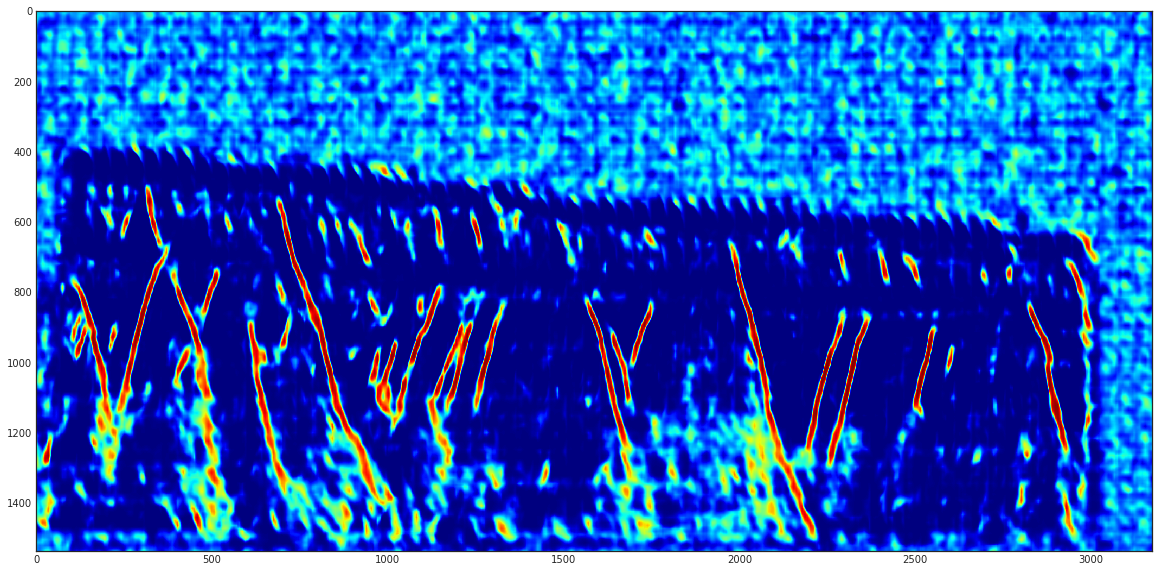

In [25]:
heatmap_img = cv2.applyColorMap((a*255).astype(np.uint8), cmapy.cmap('jet_r'))
plt.figure(figsize=(20,16))
plt.imshow(heatmap_img)
# plt.colorbar(shrink=0.5)
# plt.axis('off')
plt.show()
# fin = cv2.addWeighted(heatmap_img/255, 0.6, img_colorized/255, 0.4, 0)
# plt.figure(figsize=(20,16))
# plt.imshow(fin, vmin=0)
# # plt.colorbar(shrink=0.5)
# plt.axis('off')
# plt.show()

In [26]:
# heatmap_img = cv2.applyColorMap((a*255).astype(np.uint8), cmapy.cmap('Greens'))
# plt.figure(figsize=(20,16))
# plt.imshow(heatmap_img)
# # plt.colorbar(shrink=0.5)
# plt.axis('off')
# plt.show()
# fin = cv2.addWeighted(heatmap_img/255, 0.6, img_colorized/255, 0.4, 0)
# plt.figure(figsize=(20,16))
# plt.imshow(fin, vmin=0)
# # plt.colorbar(shrink=0.5)
# plt.axis('off')
# plt.show()

In [27]:
label_path = '/data/anyu/faulttest.npy'
fault = np.load(label_path)

(1537, 3174)


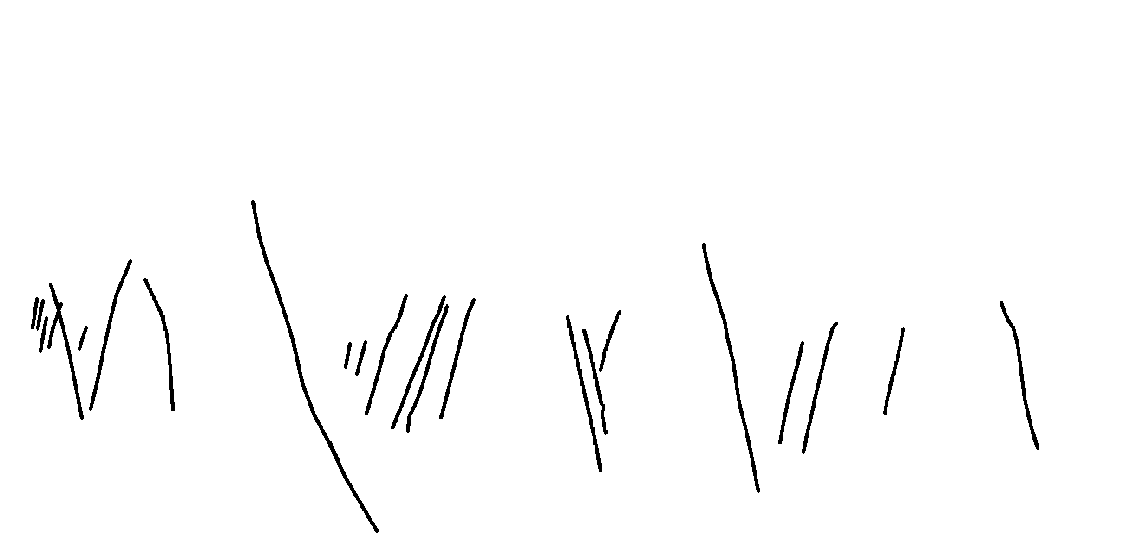

In [28]:
gt = fault[100]
print(gt.shape)
plt.figure(figsize=(20,16))
plt.imshow(gt)
plt.axis('off')
plt.show()

In [29]:
gt = fault[100,800:1300,:]
print(gt.shape)

(500, 3174)


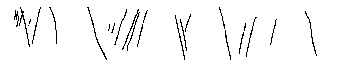

In [30]:
plt.imshow(gt)
plt.axis('off')
plt.show()

In [31]:
gt = gt.astype(np.float32)

(250, 1587)


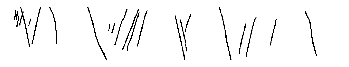

In [32]:
gt2 = cv2.resize(gt,(1587,250))
print(gt2.shape)
plt.imshow(gt2)
plt.axis('off')
plt.show()

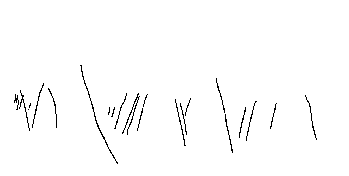

In [33]:
plt.imshow(fault[100])
plt.axis('off')
plt.show()

In [34]:
print(fault[100].shape)

(1537, 3174)


In [35]:
b = cv2.resize(fault[100],(700,1587))
print(b.shape)

TypeError: Expected cv::UMat for argument 'src'

In [ ]:
plt.imshow(b)
plt.axis('off')
plt.show()

In [ ]:
fin = cv2.addWeighted(fault[100].astype(np.float64), 0.2, seis[100], 0.8, 0)
plt.figure(figsize=(20,16))
plt.imshow(fin, cmap='seismic')
# plt.colorbar(shrink=0.5)
# plt.axis('off')
plt.show()

In [ ]:
# fin = cv2.addWeighted(fault[104].astype(np.float64), 0.2, seis[104], 0.8, 0)
# plt.figure(figsize=(20,16))
# plt.imshow(fin, cmap='seismic')
# # plt.colorbar(shrink=0.5)
# # plt.axis('off')
# plt.show()

In [ ]:
# fin = cv2.addWeighted(fault[105].astype(np.float64), 0.2, seis[105], 0.8, 0)
# plt.figure(figsize=(20,16))
# plt.imshow(fin, cmap='seismic')
# # plt.colorbar(shrink=0.5)
# # plt.axis('off')
# plt.show()

In [ ]:
# print(fault[100,337:,0:900].astype(np.float32).shape)
# print(seis[0].dtype)

In [ ]:
import cv2

In [ ]:
a = np.arange(100).reshape((10,10))
print(a)
a_s= np.resize(a,(5,5))
# a_s = cv2.resize(a,(5,5))
print(a_s)